In [22]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass

In [23]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.grid(True)

In [24]:
def parse_data_from_file(filename):
    TEMPERATURES_CSV = './sample_data/daily-min-temperatures.csv'
    times = []
    temperatures = []

    with open(TEMPERATURES_CSV) as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')

        next(reader)
        step = 0
        for row in reader:
            times.append(step)
            temperatures.append(float(row[1]))
            step += 1
    return times, temperatures

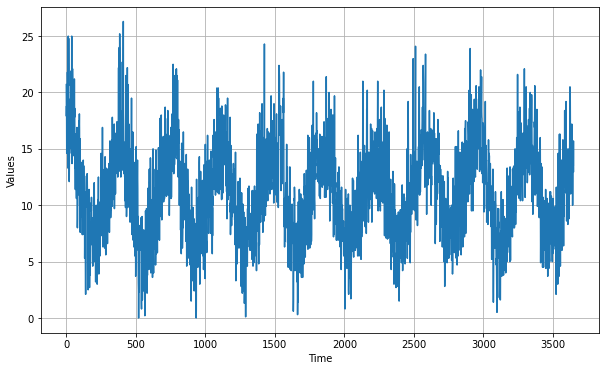

In [25]:
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2000
    WINDOW_SIZE = 30
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [26]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid
    
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [27]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [28]:
def create_uncompiled_model():

    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)    
    model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
 
])

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
    history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
 
    return model

In [30]:
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Error!")
else:
    print("Success")    

Epoch 1/100
62/62 [==============================] - 8s 41ms/step - loss: 11.1240 - mae: 11.6237 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 3s 39ms/step - loss: 11.1229 - mae: 11.6225 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 3s 40ms/step - loss: 11.1215 - mae: 11.6212 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 3s 39ms/step - loss: 11.1200 - mae: 11.6196 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 3s 40ms/step - loss: 11.1183 - mae: 11.6179 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 3s 40ms/step - loss: 11.1163 - mae: 11.6160 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 3s 40ms/step - loss: 11.1141 - mae: 11.6138 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 3s 40ms/step - loss: 11.1116 - mae: 11.6113 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 3s 44ms/step - loss: 11.1088 - mae:

In [31]:
def create_model():

    
    model = create_uncompiled_model()
    tf.random.set_seed(51)
    np.random.seed(51)
   
    optimizer = tf.keras.optimizers.SGD(learning_rate=8e-4, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])  

    return model

In [32]:
model = create_model()
history = model.fit(train_set, epochs=50)

Epoch 1/100
62/62 [==============================] - 7s 41ms/step - loss: 11.1240 - mae: 11.6237 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 3s 51ms/step - loss: 11.1229 - mae: 11.6225 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 3s 41ms/step - loss: 11.1215 - mae: 11.6212 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 3s 41ms/step - loss: 11.1200 - mae: 11.6196 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 3s 41ms/step - loss: 11.1183 - mae: 11.6179 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 3s 42ms/step - loss: 11.1163 - mae: 11.6160 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 3s 41ms/step - loss: 11.1141 - mae: 11.6138 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 3s 41ms/step - loss: 11.1116 - mae: 11.6113 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 3s 41ms/step - loss: 11.1088 - mae:

In [33]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [34]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

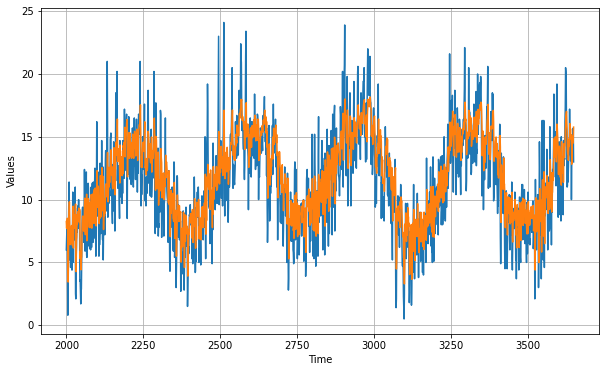

In [35]:
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [36]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.85, mae: 1.89 for forecast
